In [382]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [212]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from bokeh.plotting import *
import bokeh.plotting as bp
from bokeh.palettes import brewer
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

requests = pd.read_csv('311_requests.csv')
rent = pd.read_csv('rent_stabilization_summary.csv')

resolutions = pd.DataFrame(requests['Resolution Description'].value_counts()) #251 types of resolution description?
requests['Resolution Description'].replace(np.nan,' ', regex=True, inplace=True)
#requests = requests[requests['Resolution Description'] != ' '] #6290 out of 887869
#len(requests) #887868 entries

In [19]:
def heat_not_required(text):
    if re.findall('Heat was not required', text):
        return 1
    else:
        return 0

def multiple_offender(text):
    if re.findall('More than one complaint was received', text) or re.findall('a duplicate of a condition', text):
        return 1
    else:
        return 0
    
requests['heat_not_required']= requests['Resolution Description'].apply(lambda x: heat_not_required(x))
#requests['no_access'] = requests['Resolution Description'].apply(lambda x: no_access(x))
requests['multiple_offender'] = requests['Resolution Description'].apply(lambda x: multiple_offender(x))

def single_offense(text):
    if len(re.findall('More than one complaint was received', text)) == 0:
        if re.findall('responded to a complaint of no heat', text) and re.findall('corrected|restored', text): 
            return 1
        elif re.findall('No violations were issued', text): 
            return 2
        elif re.findall('a violation was issued', text): 
            return 3
        elif re.findall('The complaint has been closed', text) and re.findall('was not able to gain access|Heat was not required', text): 
            return 4
        elif re.findall('still open', text):
            return 5
    
def multiple_offense(text):
    if re.findall('More than one complaint was received', text) or re.findall('a duplicate of a condition', text): 
        if re.findall('corrected|restored', text): 
            return 1
        elif re.findall('No violations were issued', text): 
            return 2
        elif re.findall('Violations were previously issued', text): 
            return 3
        elif re.findall('The complaint has been closed', text) and re.findall('was not able to gain access|Heat was not required', text): 
            return 4
        elif re.findall('still open', text):
            return 5

        def offense(row):
    if row['multiple_offender'] == 0:
        return single_offense(row['Resolution Description']) 
    else:
        return multiple_offense(row['Resolution Description'])    
requests['outcome'] = requests.apply(lambda row: offense(row), axis=1)

In [25]:
outcomes_dummies = pd.get_dummies(requests['outcome'])
outcomes_dummies.columns = ['corrected','no-violation','violation','closed-no-access','open']
requests = pd.concat([requests, outcomes_dummies], axis = 1)
#requests['Closed Date'].replace(np.nan,' ', regex = True, inplace=True)
#len(requests[requests['Closed Date'] == " "]) #11310 out of 887869, 0.012 missing

def to_date(x):
    if x != " ":
        return datetime.strptime(x[:10], '%m/%d/%Y')
    else:
        return None

requests['created_date'] = requests['Created Date'].apply(lambda x: to_date(x))
requests['closed_date'] = requests['Closed Date'].apply(lambda x: to_date(x))
requests['duration'] = requests['closed_date'] - requests['created_date']
requests['duration'] = requests['duration'].astype('timedelta64[D]')
requests['year'] = requests['created_date'].apply(lambda x: x.year)

# date_format = "%m/%d/%Y"
# a = datetime.strptime('8/18/2008', date_format)
# b = datetime.strptime('9/26/2008', date_format)
# delta = b - a

requests = requests[requests['heat_not_required'] == 0] #only when heat is required
requests_short = requests[['created_date','Incident Zip', 'multiple_offender',
                        'outcome', 'duration', 'year', 'corrected','no-violation','violation','closed-no-access','open']]
requests_short = requests_short[requests_short['year'] > 2011]
requests_short.to_csv('requests_short.csv')

addresses100 = requests['Incident Address'].value_counts()[:100].index
top100 = requests[requests['Incident Address'].isin(addresses100)]
top100_short = top100[['created_date','Incident Zip', 'Incident Address', 'multiple_offender', 'Latitude', 'Longitude',
                    'year', 'corrected','no-violation','violation','closed-no-access','open']]
top100_short = top100_short[top100_short['year'] > 2011]
top100_short.to_csv('top100_short.csv')

addresses100_12 = requests[requests['year'] == 2012]['Incident Address'].value_counts()[:100].index
addresses100_13 = requests[requests['year'] == 2013]['Incident Address'].value_counts()[:100].index
addresses100_14 = requests[requests['year'] == 2014]['Incident Address'].value_counts()[:100].index

#print len(set(addresses100_12).intersection(addresses100_13))*1./len(addresses100_12)
#print len(set(addresses100_13).intersection(addresses100_14))*1./len(addresses100_13)

rent = pd.read_csv('public.csv')
requests_short = pd.read_csv('requests_short.csv')
top100_short = pd.read_csv('top100_short.csv')

###Purpose
Inspired by a hackathon organized by Heat Seek and Open Data Science in New York City [Hack for Heat](http://hack.odsc.com/), this project aims to shed some light on the heat-related problems that plagued hundred of thoursands of residents in New York City. The focus of the analysis is on heat-related requests and the rental market.

###Datasets 
NYC 311 Requests with description of "heat", 2012/01/01 to 2014/03/10
[source](https://www.google.com)

NYC rent stabiliation units trend since 2007 [source](http://blog.johnkrauss.com/where-is-decontrol/)

Zillow data, 2012/01/01 to 2014/03/10 [source](https://www.quandl.com/blog/api-for-housing-data)

### General Trends

Resolution of requests are categorized into five categories: "corrected/restore", "no violation", "violation", "closed-no-access" (case closed because the inspector cannot access the unit in the question), and "open." 


In [20]:
#color_d = {1: 'k', 2: 'b', 3: 'r', 4: 'o', 5: 'g'}
#ts.plot(x='created_date', y='rate', color=ts.outcome.map(color_d))

In [69]:
def timeseries_pct(df):
    ts = df.groupby('created_date').sum()
    ts.reset_index(inplace=True)
    #ts['created_date'] = ts['created_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
    ts['total'] = ts[['corrected','no-violation','violation','closed-no-access','open']].sum(axis=1)
    ts['corrected_pct'] = ts['corrected']/ts['total']
    ts['no-violation_pct'] = ts['no-violation']/ts['total']
    ts['violation_pct'] = ts['violation']/ts['total']
    ts['closed-no-access_pct'] = ts['closed-no-access']/ts['total']
    ts['open_pct'] = ts['open']/ts['total']
    ts['multiple_offender_pct'] = ts['multiple_offender']/ts['total']
    
    return ts
ts1 = timeseries_pct(top100_short)[['created_date', 'multiple_offender_pct']]
r1 = timeseries_pct(requests_short)[['created_date', 'multiple_offender_pct']]
ts1.set_index('created_date', inplace=True)
r1.set_index('created_date', inplace=True)

In [369]:
def plot(df, ylim):
    ts = timeseries_pct(df)
    #ax = ts.plot()
    #r1.plot(ax=ax)
    ax = ts.plot(x='created_date', y='corrected_pct', figsize=(15,8), label = 'corrected')
    ts.plot(x='created_date', y='no-violation_pct', figsize=(15,8), label = 'no-violation', color = 'g', ax=ax)
    ts.plot(x='created_date', y='violation_pct', figsize=(15,8), label = 'violation', color = 'r', ax=ax)
    ts.plot(x='created_date', y='closed-no-access_pct', figsize=(15,8), label = 'closed-no-access', color = 'gray', ax=ax)
    ts.plot(x='created_date', y='open_pct', figsize=(15,8), label = 'open', color = 'y',ax=ax)
    plt.ylim(0,1.1)
    plt.title('311 Requests for Heat-related Problems, 2010/01/01-2014/03/10, by Outcomes', fontsize=18)
    ax.set_ylabel('Percentage of Requests', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    plt.show()

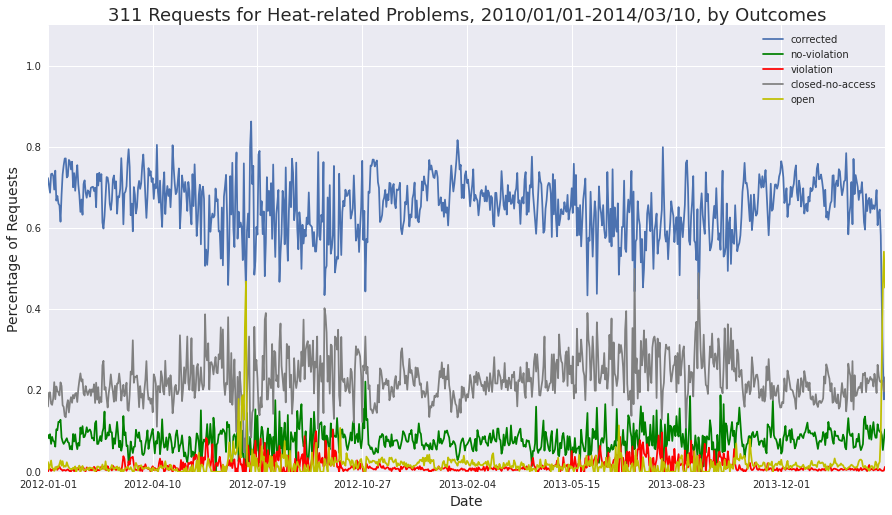

In [370]:
plot(requests_short, 1)

Most of the requests are recorded as "corrected" and the second-largest proportion of requests is closed due to no access to the building. The percentage of the requests ends in actual violations and the percentage of open requests are the lowest and very minuscule.
There is no seasonality trend with the distribution of outcome types despite the nature of the problem is seasonal.

### Multiple Offenders

A prominent pattern from the resolution description is the existence of requests that are filed for buildings that have multiple requests, past or present. How prevalent are the requests from those buildings ("multiple offenders")? The data shows that a high percentage of the total number of requests involve those "multiple offender" buildings.

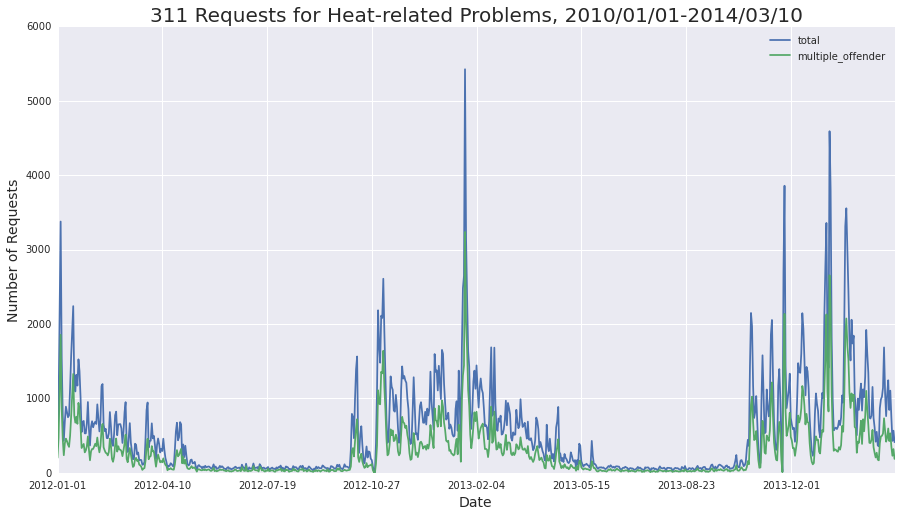

In [378]:
def timeseries(df):
    ts = df.groupby('created_date').sum()
    ts['total'] = ts[['corrected','no-violation','violation','closed-no-access','open']].sum(axis=1)
    return ts

general = timeseries(requests_short)
ax = general[['total', 'multiple_offender']].plot(figsize=(15,8))
plt.title('311 Requests for Heat-related Problems, 2010/01/01-2014/03/10', fontsize=20)
ax.set_ylabel('Number of Requests', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.show()

In [163]:
ts = timeseries_pct(requests_short)
df = ts.ix[:,14:19]
df['created_date'] = ts['created_date']
df = df.set_index(['created_date'])

categories = df.columns[:5]
data = OrderedDict()

for outcome in categories:
    data[outcome] = df[outcome]
data['x'] = df.index

In [164]:
#requests['Incident Address'].value_counts()[:100].cumsum()

In [235]:
# from collections import OrderedDict
# from bokeh.plotting import *
# import bokeh.plotting as bp
# from bokeh.palettes import brewer

# def stacked(df, categories):
#     areas = OrderedDict()
#     last = np.zeros(len(df[categories[0]]))
#     for cat in categories:
#         next = last + df[cat]
#         areas[cat] = np.hstack((last[::-1], next))
#         last = next
#     return areas

# areas = stacked(df, categories)
# colors = brewer["Spectral"][len(areas)]
# x2 = np.hstack((data['x'][::-1], data['x']))
# output_file("brewer.html", title="brewer.py example")

# p = figure(title='311 Requests for Heat-related Problems, Proportions of Outcomes, 01/01/10-03/10/14', 
#            title_text_font_size="10pt", x_axis_type = "datetime")
# for a, area in enumerate(areas):
#     p.patch(x2, areas[area], color=colors[a], legend=area, alpha=0.8, line_color=None)
# #p.patches([x2 for a in areas], list(areas.values()), color=colors, alpha=0.8, line_color=None)


# p.legend.orientation = 'bottom_right'
# bp.output_notebook()
# bp.show(p)

In [134]:
float(69629)/requests['Incident Address'].count() #80513 unique addresses
#7.8% of the requests come from the top 100 addresses or 0.01 of the addresses!!
top100map = top100_short[['Latitude', 'Longitude', 'Incident Zip', 'corrected',
                         'no-violation', 'violation', 'closed-no-access', 'open']]
top100map = top100map.groupby(['Latitude', 'Longitude', 'Incident Zip']).sum()
top100map.reset_index(inplace = True)
top100map.to_csv('top100map.csv')

In [25]:
x = rent[rent['address'].isin(addresses100)]['percentchange'] 
y = addresses100.isin(rent['address'])
addresses100[~y]
# addresses500 = requests['Incident Address'].value_counts()[:500].index
# y = rent[rent['address'].isin(addresses500)]['percentchange'] 

### Top 100 buildings in terms of requests filed
To explore the source of the requests, I identified the top 100 buildings in terms of total number of 311 requests filed. It comes as no surprise that those top 100 buildings are mostly multple offenders.

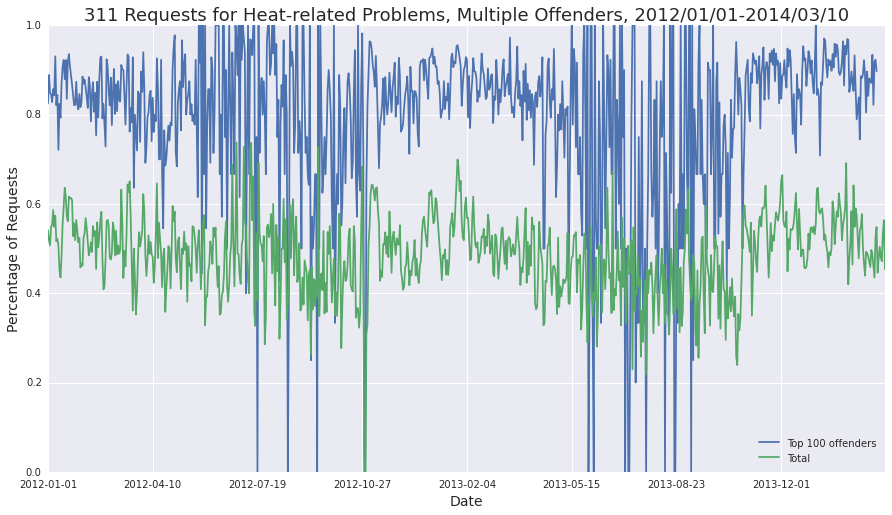

In [376]:
#Comparison graph- multiple offenders
ax = ts1.plot(figsize=(15,8))
r1.plot(ax=ax)
ax.legend(['Top 100 offenders', 'Total'], loc='lower right')
ax.set_ylabel('Percentage of Requests', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.title("311 Requests for Heat-related Problems, Multiple Offenders, 2012/01/01-2014/03/10", fontsize=18)
plt.show()


In [310]:
nyc_zip = requests['Incident Zip'].unique() #80513
nyc_zip = [x for x in nyc_zip if not np.isnan(x)]
nyc_zip = [int(x) for x in nyc_zip]
nyc_zip = sorted(nyc_zip)

In [383]:
# RZSF : Estimated Rent per Square Foot 
# MVSF Price per square foot 
import Quandl

dat = []
missing_zip = []
non_missing = []
for i in nyc_zip:
    try:
        x = "ZILL/Z" + str(i) + "_RZSF"
        mydata = Quandl.get(x, trim_start="2012-01-31", trim_end="2014-03-31", 
                        authtoken="1gyjSSAC8YoNXVXsbync")
        non_missing.append(i)
        dat.append(mydata)
    except Exception as e:
        missing_zip.append(i)
        pass

    appended_data = pd.concat(dat, axis=1) 


KeyboardInterrupt: 

In [388]:
appended_data.columns = non_missing
data = appended_data.T
data['change_RZSF'] = (data.ix[:,-1] - data.ix[:,0])/data.ix[:,0] #first value
data['avg_RZSF'] = data.mean(axis=1)
data.reset_index(inplace=True)
rsf = data[['index', 'change_RZSF', 'avg_RZSF']]
rsf.columns = ['zipcode','change_RZSF', 'avg_RZSF']
rsf.to_csv('zillow_rent.csv')

### 311 Requests and Neighborhood Rent data
To situate the heat-related problems in the rental market, I use the rent stabilization and Zillow data. 

First, are those buildings are special in any ways? For instance, are they refraining heat from the tenants to drive them out for higher rent at the market rate? I cross-referenced the 311 request data with the rent stabilization dataset(1) and found:

24% of the top 100 addresses have decreased rent stabilized units since 2007; for the top 500 addresses, it is 29%.

About a quarter of the buildings with the most heat-related requests have lost rent stabilized units since 2007. More context and data are required to determine whether this number is significantly high enough to be evidence for the above proposition.


First, I examine the correlation between the outcomes and rental data.

In [323]:
rsf = pd.read_csv('rsf.csv')
zip_dat = requests_short.groupby('Incident Zip').sum()
zip_dat.reset_index(inplace=True)       

In [324]:
merged = pd.merge(zip_dat, rsf, how='left', left_on = 'Incident Zip', right_on= 'zipcode')

Outcomes are correlated with one another. Multiple offender is not surprisingly related to all the outcomes because they have more requests filed than single-offense buildings. 

Overall, average per square foot is negatively related to requests (all outcomes); wealthier neighborhoods generated fewer requests. Change in rent per square foot is positively correlated with the number of requests. 

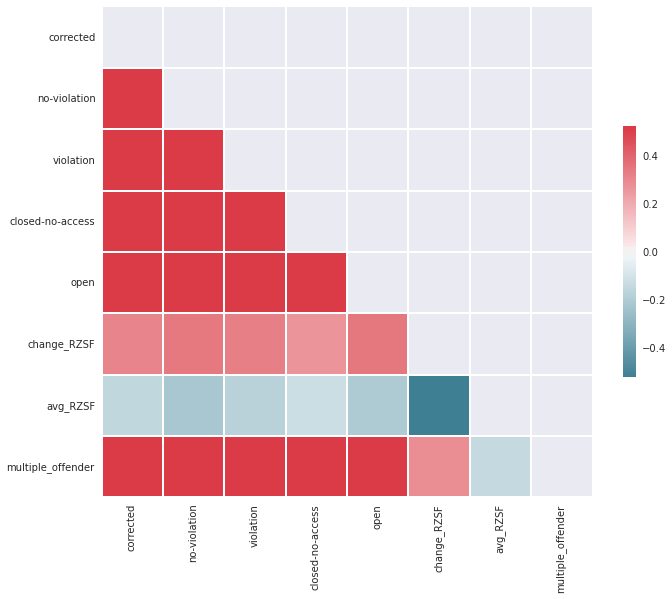

In [379]:
d = merged[['corrected', 'no-violation', 'violation', 'closed-no-access', 'open', 'change_RZSF', 'avg_RZSF', 'multiple_offender']]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

However, the change in rent per square foot and average rent per square foot has a negative relationship. This means lower-income neighborhoods have seen a higher rent increase than their wealthier counterparts(3). This characteristic could considered an aspect of gentrification.

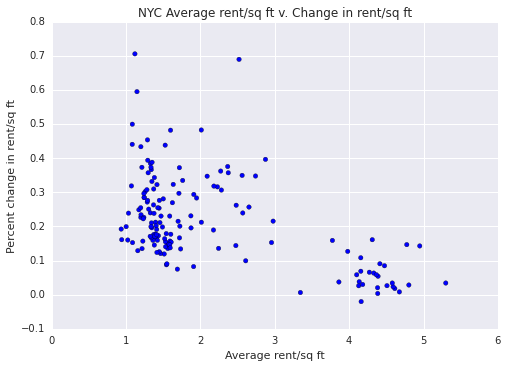

In [380]:
_ = plt.scatter(merged['avg_RZSF'], merged['change_RZSF'])
plt.ylabel('Percent change in rent/sq ft')
plt.xlabel('Average rent/sq ft')
plt.title('NYC Average rent/sq ft v. Change in rent/sq ft')
plt.figure(figsize=(12,8))
plt.show()

In [327]:
new_top100 = top100_short[top100_short['Incident Zip'].notnull()]
new_top100['Incident Zip'] = new_top100['Incident Zip'].apply(lambda x: int(x))

In [328]:
top100_z = pd.merge(new_top100, rsf, how='outer', left_on= 'Incident Zip', right_on='zipcode')

In [242]:
l1 = new_top100['Incident Zip'].values
l2 = rsf['zipcode'].values
#print len(set(l1).intersection(l2)), len(new_top100['Incident Zip'].unique()) 


The picture looks different for the top 100 multple offenders(2). For those buildings, "corrected" outcome is highly correlated with being multiple offenders, while negatively correlated with other outcomes. This implies that most of the requests from the top 100 offenders are corrected. 

Another difference is that in thouse 100 buildings, the rent data (average rent per square foot and change in rent per square foot) has very little correlation with requests overall. 

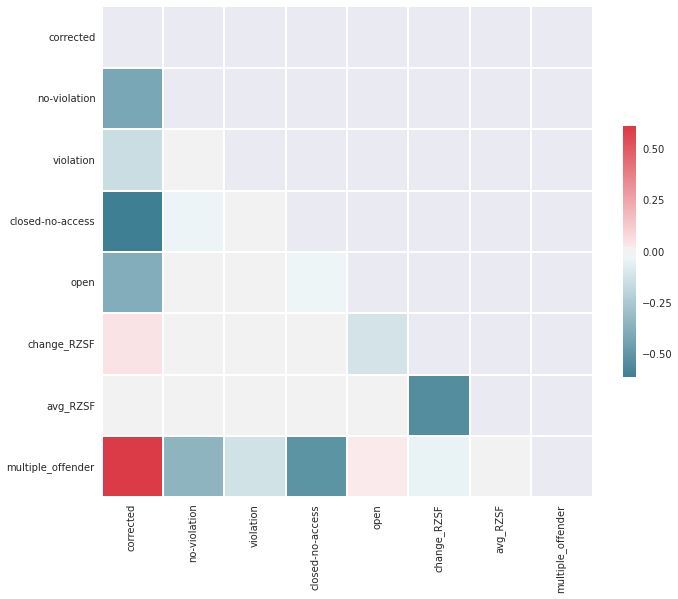

In [381]:
d1 = top100_z[['corrected', 'no-violation', 'violation', 'closed-no-access', 'open', 'change_RZSF', 'avg_RZSF', 'multiple_offender']]
# Compute the correlation matrix
corr1 = d1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

In [656]:
def timeseries_map(df):
    ts = df.groupby(['Incident Zip']).sum()
    ts.reset_index(inplace=True)
    #ts['created_date'] = ts['created_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
    ts['total'] = ts[['corrected','no-violation','violation','closed-no-access','open']].sum(axis=1)
    ts['corrected_pct'] = ts['corrected']/ts['total']
    ts['no-violation_pct'] = ts['no-violation']/ts['total']
    ts['violation_pct'] = ts['violation']/ts['total']
    ts['closed-no-access_pct'] = ts['closed-no-access']/ts['total']
    ts['open_pct'] = ts['open']/ts['total']
    ts['multiple_offender_pct'] = ts['multiple_offender']/ts['total']
    ts['avg_duration'] = ts['duration']/ts['total']
    
    return ts

In [197]:
requests['Total'] = requests[['corrected','no-violation','violation','closed-no-access','open']].sum(axis=1)
requests_latlong = requests[['created_date', 'year','Latitude', 'Longitude', 'Total']]
requests_latlong = requests_latlong[requests_latlong['year'] > 2011]
requests_latlong = requests_latlong.groupby(['created_date', 'Latitude', 'Longitude']).sum()
requests_latlong.reset_index(inplace=True)
requests_latlong.to_csv('requests_latlong.csv')

### Geographic Patterns

Overall, areas above the Central Park in Manhattan, many areas in the Bronx and Flatbush/Crown Heights/Bed-Sty in Brooklyn have the highest numbers of requests. Looking at outcome types, areas with higher number of requests also have a higher percentage of the requests being "corrected/restored," although not for all cases.

In [334]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://pfan.cartodb.com/viz/0e498dba-a10a-11e5-9b4c-0e3ff518bd15/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

The number of requests by zipcodes is very similar to the number buildings that have multiple requests filed. 

In [331]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://pfan.cartodb.com/viz/7df5404e-a10c-11e5-949e-0e674067d321/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

In [161]:
def zipcode_pct(df):
    ts = df.groupby('Incident Zip').sum()
    ts.reset_index(inplace=True)
    #ts['created_date'] = ts['created_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
    ts['total'] = ts[['corrected','no-violation','violation','closed-no-access','open']].sum(axis=1)
    ts['corrected_pct'] = ts['corrected']/ts['total']
    ts['no-violation_pct'] = ts['no-violation']/ts['total']
    ts['violation_pct'] = ts['violation']/ts['total']
    ts['closed-no-access_pct'] = ts['closed-no-access']/ts['total']
    ts['open_pct'] = ts['open']/ts['total']
    ts['multiple_offender_pct'] = ts['multiple_offender']/ts['total']
    
    return ts

In [162]:
zipcode_pct(requests_short)[['Incident Zip', 'total', 'corrected_pct',
                               'no-violation_pct', 'violation_pct', 'closed-no-access_pct', 
                               'open_pct', 'multiple_offender_pct']].to_csv('requests1.csv')
zipcode_pct(requests_short)[['Incident Zip', 'multiple_offender',
                             'multiple_offender_pct']].to_csv('multiple_offender.csv')

Overall, summer months fewer requests. However, throughout the entire year the request-concentrated areas in Bronx and Brooklyn from previous maps have filed requests at a higher rate than other neighborhoods.  The heat problem might be a symptom of a larger issue with accommodation in those buildings. 

In [231]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://pfan.cartodb.com/viz/91e9cebe-a114-11e5-9487-0ea31932ec1d/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

### What do we know?
####Finding no.1:
* 311 requests about heat problems are likely to found in neighborhoods with lower rent, and also those with increase in rent per square foot (which tend to have lower average rent). 
* This lends some evidence that potentially gentrifying neighborhoods, defined as those with increased rent in lower-rent zipcodes, experience more heat problems. 
* The requests filed against multiple offenders are also likely to be found in potentially gentrifying neighborhoods.

####Finding no.2:
* Neighborhoods with more requests also have a higher percentage of the requests being "corrected." 
* But consider this fact: from 2012 to 2013, 44% of the buildings in the top 100 buildings of total requests are the same. From 2013 to 2014, it is 31%. This suggests that a siginificant portion of multiple offerns are the same buildings year after year.
* Problems are not resolved permanently in those buildings since the number of requests filed against them continue to be high the year after.
* This makes one questions what does it really mean to have a request "corrected. More investigation are needed to understand the source of lack of heat problems in those buildings. 

####Finding no.3:
* Requests without access (92809) have 0 cases corrected, 3386 ending in violation (3.6%), 89413 ending in closed requests (96%). 
* Requests without access is a signal for a problematic residence where the problem is routinely overlooked.

###Take Away


#### * One major problem with all the findings is the selection bias inherent in this data: we are only looking at requests that were successfully filed. Many problems remained unheard because the residents affected cannot complete the steps of filing a request. What we see here could be an under-estimated number for many neighborhoods.  

#### * We should view the high rate of "corrected" requests with caution as well. It is possible that those who were able to file requests are in positions to get the landlord to correct the problem, while those fail to file tend to have no power over the situations. 

###[How to submit a request](http://www1.nyc.gov/site/hpd/renters/complaints-and-inspections.page)
###[Guide to solve lack of heat problem](http://metcouncilonhousing.org/sites/default/files/Met_Council_on_Housing_Heat_and_Hot_Water_Sheet.pdf)
###[Check out Heat Seek!](http://heatseeknyc.com/team)

####Technical notes:
<br>(1) There are 44619 addresses in the rent stabliziation data, and 311 requests data has 80513 addresses. The rent stabilization data hence does not cover all addresses for which a request was filed. For example, 86 out of top 100 addresses in requests are found in the rent stabliziation dataset. The remaining 14 addresses are mostly outside Manhattan.</br>
<br>(2) 34 out of 47 zipcodes covering the top 100 buildings have corresponding Zillow data.</br>
<br>(3) Not all zipcodes from the requests data have corresponding rent per square foot data from Zillow.</br>

I am happy to provide codes and the datasets used to produce this analysis upon request if you visit my github [page](http://github.com/PeggyFan).
